In [1]:
from typing import List
import numpy as np
from sage.all import *
_=singular.lib('sing.lib')
singular.eval('LIB "critic01.lib"')

'// ** loaded critic01.lib (0.01,2002/02/11")'

In [2]:
class LefschetzFibration:
    def __init__(self, variables: List[Expression], domain_eq: Expression, fibration_eq: Expression) -> None:
        self.variables = variables
        self.domain = domain_eq
        self.fibration = fibration_eq
    
    def __call__(self, argument):
        return self.fibration.subs(argument) 
    
    def get_critical_points(self):
        """Returns the set of critical points."""
        G = self.domain
        f = self.fibration
        a = self.variables[-1]
        variables = self.variables[:-1]

        constraints = [G==0]
        constraints.extend([G.diff(variable) == a*f.diff(variable) for variable in variables])
       
        points = solve(constraints, self.variables)
        print(constraints)

        return points
    
    def get_critical_values(self):
        "Returns the set of critical values."
        crits = self.get_critical_points()
        return [self.__call__(x) for x in crits]
    
    def get_fibre(self, point, variable=None): 
        """Returns the definig equation (or equations) for the fibre over 'point' as a list. Specify 'variable'
        to solve the equation 'f = t' for the variable specified. If no variable is chosen,
        the first one is taken by default."""
        if variable is None:
            variable = self.variables[0]

        # Solve {f == t} for the specified variable
        solved_eqns = solve(self.fibration == point, variable)

        # Substitute in the defining equation for the domain

        return [self.domain.subs(eqn.simplify()) for eqn in solved_eqns]

    def milnor_number(self, point):
        """Returns the Milnor number of the fibre over 'point'. The fibre should be generic, so the function will return 
        an error if 'point' is a critical value."""

        fibre = self.get_fibre(point)

        poly = fibre[0] - point

        occuring_variables = []
        for var in self.variables:
            if str(var) in str(poly):
                occuring_variables.append(var)

        varstring = ', '.join(str(var) for var in occuring_variables)
        varstring = f'({varstring})'

        ring = singular.ring(0, varstring, 'dp')
        poly_singular = singular.poly(str(poly)) 

        return poly_singular.milnor()

    def bodin_crit(self, point):
        """Calls the crit function from the singular library written by
        Arnaud Bodin, to be evaluated at 'point'."""

        fibre = self.get_fibre(point)

        poly = fibre[0] - point

        occuring_variables = []
        for var in self.variables:
            if str(var) in str(poly):
                occuring_variables.append(var)

        varstring = ', '.join(str(var) for var in occuring_variables)
        varstring = f'({varstring}, t)'

        print(varstring)

        singular.eval(f'ring r=0,{varstring},dp')
        singular.eval(f'poly f={str(poly)}')
        response = singular.eval('crit(f)')

        return response

    





In [3]:
def NumericalRoots(expr: Expression):
    """Returns the numerical roots of the polynomial 'expr'."""
    coeffs = expr.coefficients(sparse=False)
    coeffs = [complex(coefficient) for coefficient in coeffs]
    return np.polynomial.polynomial.polyroots(coeffs)


## Initialize the Lefschetz Fibration and plot critical values

In [4]:
# Declare variables to take values in complex numbers
x,y,z,a = var('x, y, z, a', domain = CC)

# Variables to use to compute the Milnor number at infinity



# Define a real parameter

t = var('t', domain = CC)
# alpha = var('alpha', domain = CC)

# Equation of affine surface
G_eq = x^3 + x*y^2 + z^2 -1
# G_eq = G_eq.subs(alpha = 9)

# Define Lefschetz fibration from Casals-Murphy p.40
fibration_eq = x+y

# Define Lefschetz bifibration rho

rho_eq = x

f = LefschetzFibration([x,y,z,a], G_eq, fibration_eq)

In [5]:
crit_points_f = f.get_critical_points()
crit_values_f = f.get_critical_values()

len(crit_points_f)


[x^3 + x*y^2 + z^2 - 1 == 0, 3*x^2 + y^2 == a, 2*x*y == a, 2*z == 0]
[x^3 + x*y^2 + z^2 - 1 == 0, 3*x^2 + y^2 == a, 2*x*y == a, 2*z == 0]


4

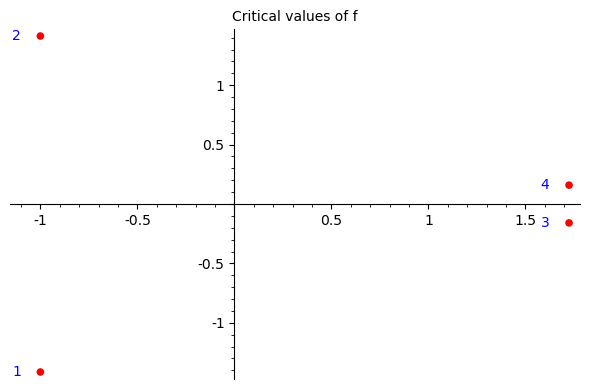

In [6]:
plot = Graphics()

for i, w in enumerate(crit_values_f):
    # Plot the point
    plot += points((w.real(), w.imag()), size=30, color='red')
    
    # Annotate the point with its index
    plot += text(str(i+1), (w.real()-0.1, w.imag()), color='blue', fontsize=10, horizontal_alignment='right')

# Display the plot
show(plot, title="Critical values of f")

## Determine the vanishing cycles of $\rho$

This may only work where we express the regular fibre of the Lefschetz fibration as a branched cover of $\mathbb{C}$ via $\rho$, so that the fibres are discrete.

In [7]:
# Choice of regular fibre. In this case, 0 is a regular fibre.


fibre_t = f.get_fibre(t, y)[0].simplify()
fibre_0 = fibre_t.subs(t==0)
fibre_t

(t - x)^2*x + x^3 + z^2 - 1

In [8]:
# Define the bifibration on a regular fibre

rho = LefschetzFibration([x, y, z, a], fibre_0, -3*x+z)
crit_points_rho = rho.get_critical_points()
crit_values_rho = rho.get_critical_values()

print(f'points: {len(crit_points_rho)}, values: {len(crit_values_rho)}')

[2*x^3 + z^2 - 1 == 0, 6*x^2 == a, 0 == 0, 2*z == 0]
[2*x^3 + z^2 - 1 == 0, 6*x^2 == a, 0 == 0, 2*z == 0]
points: 6, values: 6


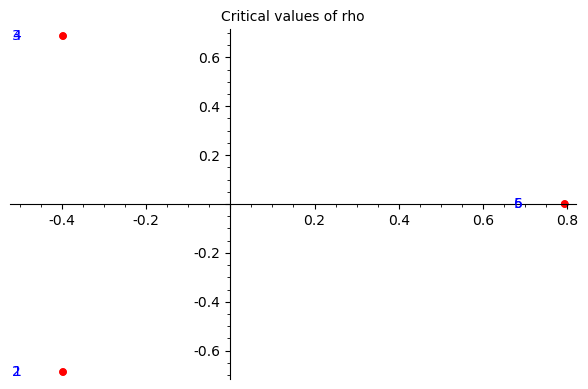

In [9]:
plot = Graphics()

for i, w in enumerate(crit_values_rho):
    # Plot the point
    plot += points((w.real(), w.imag()), size=30, color='red')
    
    # Annotate the point with its index
    plot += text(str(i+1), (w.real()-0.1, w.imag()), color='blue', fontsize=10, horizontal_alignment='right')

# Display the plot
show(plot, title="Critical values of rho")

In [10]:
fibre_rho_t = rho.get_fibre(t, z)[0]
fibre_rho_0 = rho.get_fibre(0, z)[0]

# for our dimension, the fibres of rho consist of isolated points. Solving for them amounts to reducing the
# defining equation to a polynomial in one variable, and then solving for that variable

sols = solve(fibre_rho_0, x)

IndexError: list index out of range

In [11]:
# Set initial and target index for the path to be evaluated
initial = 4
target = 5
steps = 100

In [12]:
fibres_initial = []
for s in np.linspace(0,1,steps+1):
    value = complex(s*crit_values_rho[initial])
    if value.imag == 0:
        value = value.real
    fibre_rho_s = fibre_rho_t.subs(t==value)

    sols_s = NumericalRoots(fibre_rho_s)
    fibres_initial.extend(sols_s)


fibres_initial = np.array(fibres_initial)

fibres_target = []
for s in np.linspace(0,1,steps+1):
    value = complex(s*crit_values_rho[target])
    if value.imag == 0:
        value = value.real
        
    fibre_rho_s = fibre_rho_t.subs(t==value)
    sols_s = NumericalRoots(fibre_rho_s)
    fibres_target.extend(sols_s)


fibres_target = np.array(fibres_target)


In [13]:
p_reg = fibre_rho_t.subs(t==0)
sols_0 = NumericalRoots(p_reg)
plot_points_highlight_reg = points([(value.real, value.imag) for value in sols_0], color='red', size=30)

p_crit_init = fibre_rho_t.subs(t==crit_values_rho[initial])
sols_init = NumericalRoots(p_crit_init)
plot_points_highlight_init = points([(value.real, value.imag) for value in sols_init], color='purple', size=30)

p_crit_target = fibre_rho_t.subs(t==crit_values_rho[target])
sols_target = NumericalRoots(p_crit_target)
plot_points_highlight_target = points([(value.real, value.imag) for value in sols_target], color='orange', size=30)

plot_points_highlight = plot_points_highlight_reg + plot_points_highlight_init + plot_points_highlight_target

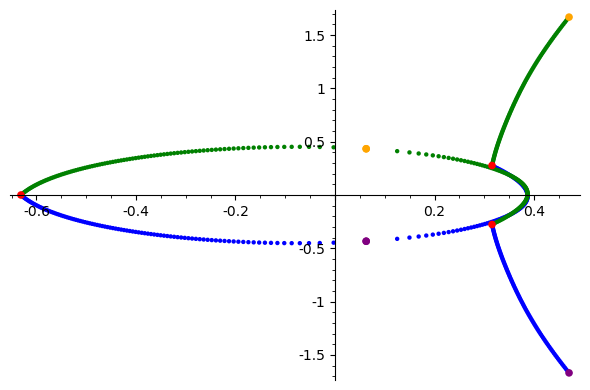

In [14]:
plot_points = [(value.real(), value.imag()) for value in crit_values_rho]
scatter_plot(plot_points, marker='s', title='Branch Points of rho')

In [11]:
target_fibre = crit_values_f[0] # Choose the index of the corresponding critical value of f to which we study a matching path

origin_fibre = 0 # Choose the initial point for the matching path. Complex numbers should be written as x + y * I.

[2*x^3 + z^2 - 1 == 0, 6*x^2 == a, 0 == 0, 2*z == 0]
[2*x^3 + z^2 - 1 == 0, 6*x^2 == a, 0 == 0, 2*z == 0]


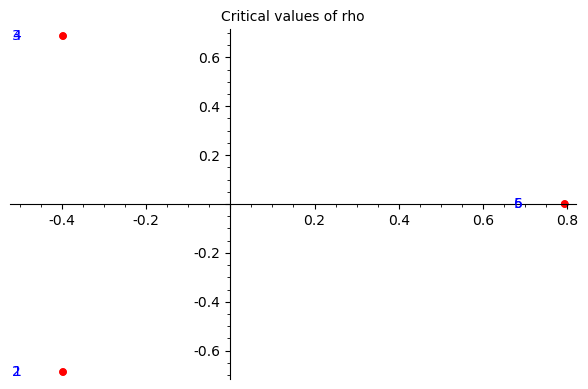

In [12]:
fibre_t = f.get_fibre(t, y)[0].simplify()
fibre_origin = fibre_t.subs(t==origin_fibre)

rho_eq_t = rho_eq.subs(y==fibre_t)
rho_eq_origin = rho_eq_t.subs(t==origin_fibre)

rho = LefschetzFibration([x, y, z, a], fibre_origin, rho_eq_origin)
crit_points_rho = rho.get_critical_points()
crit_values_rho = rho.get_critical_values()


plot = Graphics()

for i, w in enumerate(crit_values_rho):
    # Plot the point
    plot += points((w.real(), w.imag()), size=30, color='red')
    
    # Annotate the point with its index
    plot += text(str(i+1), (w.real()-0.1, w.imag()), color='blue', fontsize=10, horizontal_alignment='right')

# Display the plot
show(plot, title="Critical values of rho")

In [13]:
matching_path = {}
for s in np.linspace(0,1,71):
    fibre_s = fibre_t.subs(t==(1-s)*origin_fibre + s*target_fibre)
    rho_s = LefschetzFibration([x, y, z, a], fibre_s, rho_eq_t.subs(t==(1-s)*origin_fibre + s*target_fibre))
    matching_path[s] = rho_s.get_critical_values()


[2*x^3 + z^2 - 1 == 0, 6*x^2 == a, 0 == 0, 2*z == 0]
[(x + 0.014285714285714285*I*sqrt(2) + 0.014285714285714285)^2*x + x^3 + z^2 - 1 == 0, (x + 0.014285714285714285*I*sqrt(2) + 0.014285714285714285)^2 + 2*(x + 0.014285714285714285*I*sqrt(2) + 0.014285714285714285)*x + 3*x^2 == a, 0 == 0, 2*z == 0]
[(x + 0.02857142857142857*I*sqrt(2) + 0.02857142857142857)^2*x + x^3 + z^2 - 1 == 0, (x + 0.02857142857142857*I*sqrt(2) + 0.02857142857142857)^2 + 2*(x + 0.02857142857142857*I*sqrt(2) + 0.02857142857142857)*x + 3*x^2 == a, 0 == 0, 2*z == 0]
[(x + 0.04285714285714286*I*sqrt(2) + 0.04285714285714286)^2*x + x^3 + z^2 - 1 == 0, (x + 0.04285714285714286*I*sqrt(2) + 0.04285714285714286)^2 + 2*(x + 0.04285714285714286*I*sqrt(2) + 0.04285714285714286)*x + 3*x^2 == a, 0 == 0, 2*z == 0]
[(x + 0.05714285714285714*I*sqrt(2) + 0.05714285714285714)^2*x + x^3 + z^2 - 1 == 0, (x + 0.05714285714285714*I*sqrt(2) + 0.05714285714285714)^2 + 2*(x + 0.05714285714285714*I*sqrt(2) + 0.05714285714285714)*x + 3*x^2 =

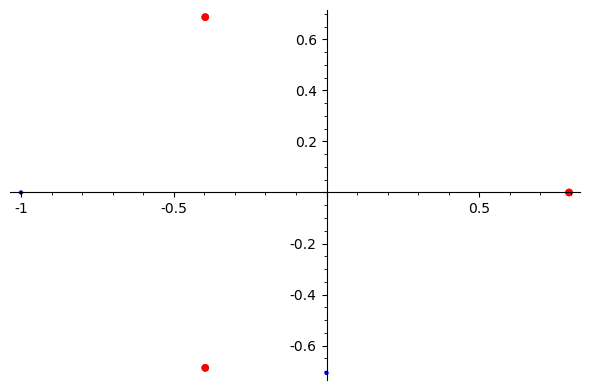

In [15]:
plot_points_highlight = points([(value.real(), value.imag()) for value in matching_path[0]], color='red', size=30)



plot_points = points([(value.real(), value.imag()) for crit_values in list(matching_path.values()) for value in crit_values])
plot = plot_points+plot_points_highlight
plot.show()

## Computing the homotopy type of a regular fibre

In [69]:
f.milnor_number(0)

4

In [79]:
rho.milnor_number(0)

TypeError: Singular error:
   ? `I` is not defined
   ? error occurred in or before STDIN line 40: `def sage20=-1/3*(z - I)*z^2 + 2/3*z + 1;`